In this notebook I check consistency of my code and results from Risk Institute of EDHEC.


Inputs:
- parameters for stochastic simulations

<img src="pictures/Input parameters.png" width="400">


- inputs for period t=0 are taken as long term values of SR, stock returns, volatility and risk free rate
- apart from reported correlations I use correlation of interest rate with other parameters = 0; correlation of stock volatility and shar[e rati0 = +76.7%
- 20 years investment horizon
- 100 initial wealth
- 0.1 invested in risky asset and 0.9 invested in zero-coupon bond

### !!! NOTE: Used lambda r was 0.53%, not 53%, because we discussed that in class

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import market_stochastic_simulation as mss
import retirement_client as pensioner

# 1. Market Simulation Code

$
\begin{cases}
r_{t+dt} = r_t + \kappa_r (\bar{lt_r} - r_t) dt + \sigma_r \sqrt{dt} Z_t^r\\
SR_{t+dt} = SR_t + \kappa_sr (\bar{lt_sr} - SR_t) dt + \sigma_SR \sqrt{dt} Z_t^SR\\
V_{t+dt} = V_t + \kappa_v (lt_V - V_t) dt + \sigma_V \sqrt{V_t} \sqrt{dt} Z_t^V\\
S_{t+dt} = S_t \times \exp \left( \left( r + \bar{\lambda_0} \sigma_t - \frac{1}{2} \sigma_t^2 \right) dt + \sigma_t \sqrt{dt} Z_t^S \right) \\
\end{cases}
$

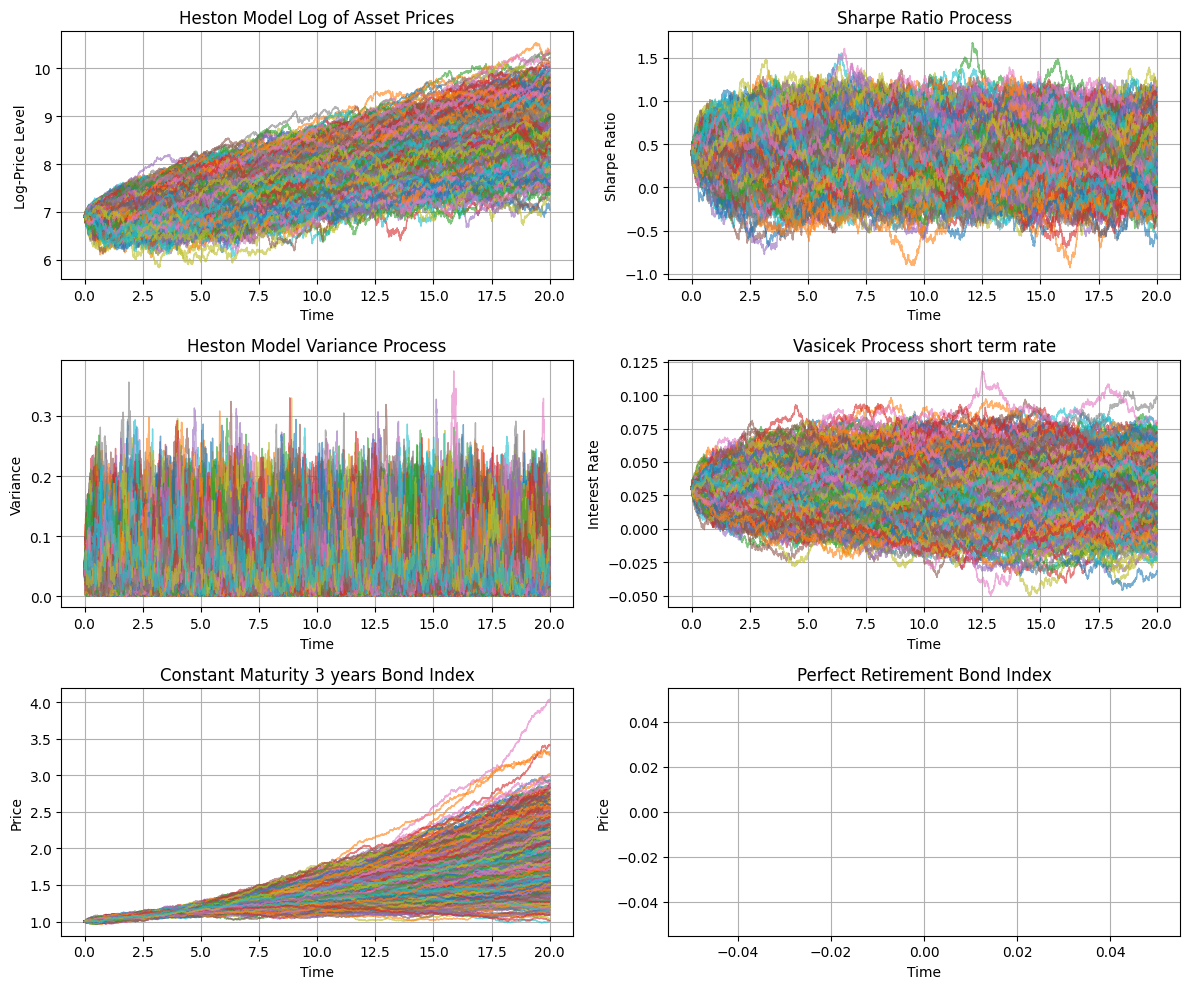

In [2]:
# Parameters
S0 = 1000.0              # asset price
T = 20                  # time in years
N = 252*T              # number of time steps in simulation
M = 1000                # number of simulated paths
seed = 124              # simulation seed

simulated_market = mss.MarketSimulator(T,N,M,seed, S0)
simulated_market.plot_market_simulation()

## Initialize client

Find cash flows the client needs

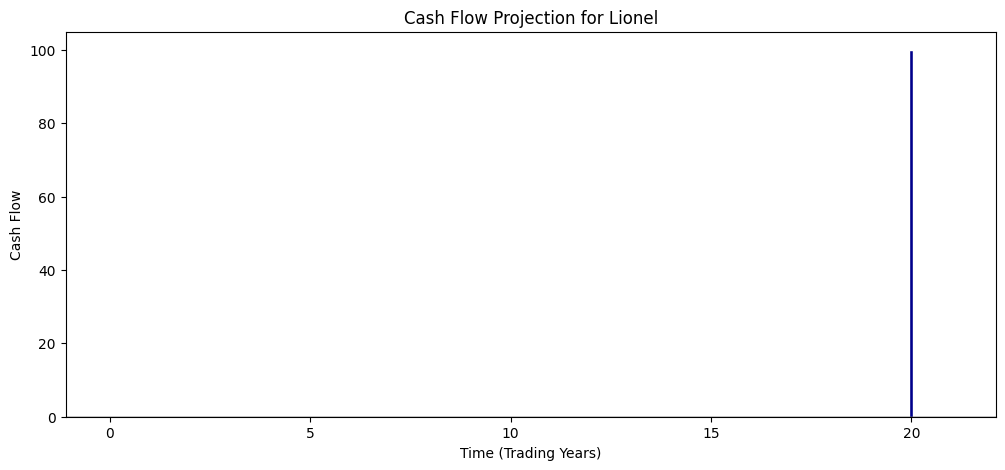

In [3]:
client = pensioner.RetirementClient("Lionel",
                           accumulation_years=20,
                           accumulation_cash_flow=0,
                           decumulation_years=1,
                           decumulation_cash_flow=100,
                           periodicity = 12)

client.plot_cash_flows()

Now we know cash flows that the client needs. Hence, we can simulate perfect zero coupon bond for him

In [4]:
simulated_market.calculate_perfect_retirement_bond(client)

Simulating scenarios: 100%|█████████████████| 1000/1000 [04:23<00:00,  3.80it/s]
/Users/aleksandrmikhailov/Desktop/Goal-Based-Investing/market_stochastic_simulation.py:295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  retirement_bond_p.loc[:, simulation_number] = result[i]


Plot the market and the zero coupon bond.

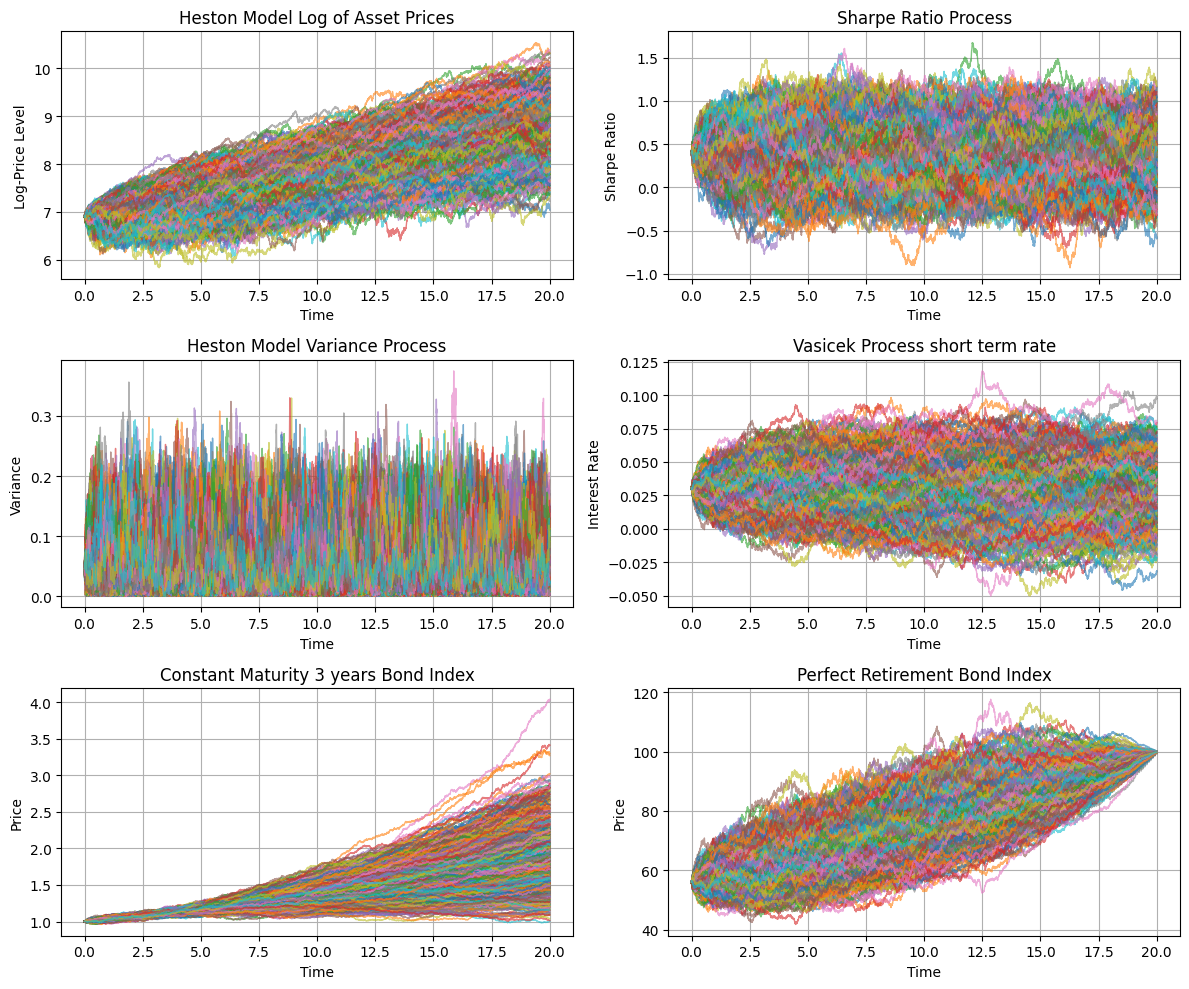

In [5]:
simulated_market.plot_market_simulation()

## Find fixed mix fund performance (rebalanced daily)

In [6]:
risky_asset_returns  = simulated_market.S_p.pct_change().iloc[1:,:]
safe_asset_returns  = simulated_market.retirement_bond_p.pct_change().iloc[1:,:]

In [7]:
FM_fund_performance_0 = risky_asset_returns*0+safe_asset_returns*1
FM_fund_performance_10 = risky_asset_returns*0.1+safe_asset_returns*0.9
FM_fund_performance_20 = risky_asset_returns*0.2+safe_asset_returns*0.8
FM_fund_performance_30 = risky_asset_returns*0.3+safe_asset_returns*0.7

initial_wealth = 100

portfolio_wealth_0 = (FM_fund_performance_0+1).cumprod()*100
portfolio_wealth_10 = (FM_fund_performance_10+1).cumprod()*100
portfolio_wealth_20 = (FM_fund_performance_20+1).cumprod()*100
portfolio_wealth_30 = (FM_fund_performance_30+1).cumprod()*100

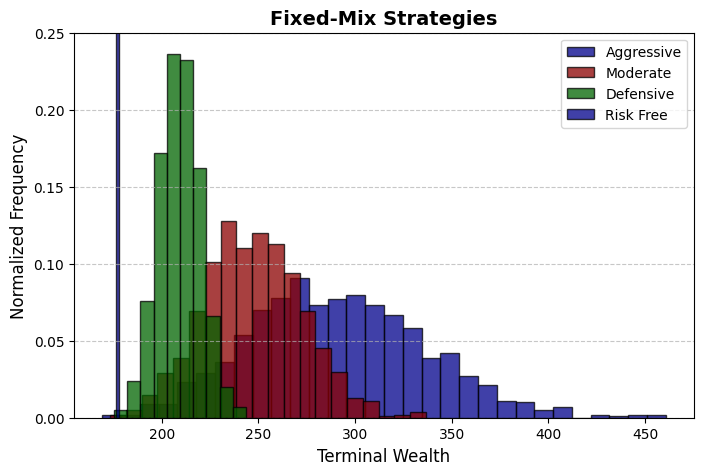

In [8]:
# Create figure
plt.figure(figsize=(8, 5))

# Define colors and labels
colors = ["darkblue", "darkred", "darkgreen", "darkblue"]
labels = ["Aggressive", "Moderate", "Defensive", "Risk Free"]
bins_list = [30, 20, 10, 1]  # Different bin sizes

# Iterate over each strategy
for i, (portfolio, bins, color, label) in enumerate(zip(
    [portfolio_wealth_30, portfolio_wealth_20, portfolio_wealth_10, portfolio_wealth_0], 
    bins_list, colors, labels)):

    # Compute histogram data (without density=True)
    n, bins = np.histogram(portfolio.iloc[-1, :], bins=bins)
    
    # Normalize so the sum is 1
    n = n / n.sum()

    # Plot manually using plt.bar
    plt.bar(bins[:-1], n, width=np.diff(bins), color=color, edgecolor="black", alpha=0.75, label=label)

# Titles and Labels
plt.title("Fixed-Mix Strategies", fontsize=14, fontweight='bold')
plt.xlabel("Terminal Wealth", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Legend
plt.legend()

plt.ylim(0,0.25)
# Show the improved plot
plt.show()

In [9]:
portfolio_wealth_10.iloc[-1,:].mean().round(2)

212.45

Resulting wealth is significantly different from the simulation results obtained in "Dynamic Liability-Driven Investing Strategies: The Emergence of a New Investment Paradigm for Pension Funds? — February 2014":

<img src="pictures/FM_strategy.png" width="400">

## Why are results so different?

Investment 100% of assets is zero coupon bond would give around 280-300 in the example provided by EDHEC risk institute.

At the same time my code shows investment of 100 in zero-coupon bond would give 1/0.56*100 = 178

The number is off by nearly 100 wealth!

In [10]:
np.mean(portfolio_wealth_10.iloc[-1])

212.45206750527194

In [11]:
np.std(portfolio_wealth_10.iloc[-1])

10.779434076539587

Defensive strategy standard deviation is also different from the one that I found. EDHEC Risk Institute finds that it is equal to 5%, I find it equal to 10.8%

<img src="pictures/defensive strategy.png" width="700">

## Another proof that results in paper are wrong

Let's take parameters for interest rate process. Then Calculate zero coupon bond price based on them. Then Find zero-coupon bond price for 20 years period.


Here is extract from the "MarketSimulator" class. Let's use it

In [28]:
def vasicek_zcb_price(self, r_t, tau):
    """
    Computes the price P(t, t+tau) of a zero-coupon bond under the Vasicek model.

    Parameters:
    - r_t: Short rate at time t
    - tau: Time to maturity in years (default = 3 years)

    Returns:
    - Price of the zero-coupon bond P(t, t+tau)
    """
    # Compute B(t, T) factor in Vasicek model
    B = (1.0 - np.exp(-self.kappa_r * tau)) / self.kappa_r

    # Compute A(t, T) factor in Vasicek model
    A_term1 = (self.lt_r_q - (self.sigma_r**2) / (2.0 * self.kappa_r**2)) * (B - tau)
    A_term2 = (self.sigma_r**2) * B**2 / (4.0 * self.kappa_r)
    A = A_term1 - A_term2  # Fixed: Applied exponentiation as per formula

    # Compute bond price using Vasicek formula
    return np.exp(A-B * r_t)

Find the price of zero coupon bond

In [29]:
zc_ond_price_20_years = vasicek_zcb_price(simulated_market, 0.03, 20)
zc_ond_price_20_years

0.5625065810746642

Given this price it is easy to find return required for the bond

In [20]:
returns_on_bond = 1 / zc_ond_price_20_years-1
returns_on_bond

0.7853688432667261

Recall that the Risk Institute Found 314% return (100->314) for defensive strategy. Let's find return that the stock should have had

In [15]:
return_portfolio  = 314 / 100 - 1
print(f'whole portfolio has return {return_portfolio*100}%')

weight_stock = 0.1
weight_bond = 0.9
print(f'then stock return in FM should have been equal to {np.round((return_portfolio - weight_bond * returns_on_bond) / weight_stock,2)*100}:%')

whole portfolio has return 214.0%
then stock return in FM should have been equal to 1433.0:%


## Additional check of interest rate

In [32]:
# Given parameters from the table
b = 3.06 / 100  # Convert percentage to decimal
a = 0.13
sigma = 0.98 / 100  # Convert percentage to decimal
lambda_risk = -53.00 / 100 / 100 # Convert percentage to decimal
r_t = 0.03  # Initial short-term interest rate
T = 20  # 20-year bond
t = 0  # Current time

# Adjusted mean reversion level under risk-neutral measure
b_Q = b - (lambda_risk * sigma / a)

# Compute B(t,T)
B_tT_lambda = (1 - np.exp(-a * (T - t))) / a

# Compute A(t,T) with lambda
A_tT_lambda = (b_Q - (sigma**2 / (2 * a**2))) * (B_tT_lambda - (T - t)) - (sigma**2 * B_tT_lambda**2) / (4 * a)

# Compute bond price for 20-year ZC bond
P_20_lambda = np.exp(A_tT_lambda - B_tT_lambda * r_t)

# Display result
P_20_lambda

0.5567473241959291

Still same result. Still wrong.